<a href="https://colab.research.google.com/github/udlbook/udlbook/blob/main/Notebooks/Chap19/19_4_Temporal_Difference_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 19.4: Temporal difference methods**

This notebook investigates temporal difference methods for  tabular reinforcement learning as described in section 19.3.3 of the book

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.

Thanks to [Akshil Patel](https://www.akshilpatel.com) and [Jessica Nicholson](https://jessicanicholson1.github.io) for their help in preparing this notebook.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output
from time import sleep
from copy import deepcopy

In [17]:
# Get local copies of components of images
!wget https://raw.githubusercontent.com/udlbook/udlbook/main/Notebooks/Chap19/Empty.png
!wget https://raw.githubusercontent.com/udlbook/udlbook/main/Notebooks/Chap19/Hole.png
!wget https://raw.githubusercontent.com/udlbook/udlbook/main/Notebooks/Chap19/Fish.png
!wget https://raw.githubusercontent.com/udlbook/udlbook/main/Notebooks/Chap19/Penguin.png

--2024-08-27 11:10:36--  https://raw.githubusercontent.com/udlbook/udlbook/main/Notebooks/Chap19/Empty.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12495 (12K) [image/png]
Saving to: 'Empty.png.5'

     0K .......... ..                                         100% 6.89M=0.002s

2024-08-27 11:10:36 (6.89 MB/s) - 'Empty.png.5' saved [12495/12495]

--2024-08-27 11:10:36--  https://raw.githubusercontent.com/udlbook/udlbook/main/Notebooks/Chap19/Hole.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9440 (9.2K) [image/png]
Sav

In [18]:
# Ugly class that takes care of drawing pictures like in the book.
# You can totally ignore this code!
class DrawMDP:
  # Constructor initializes parameters
  def __init__(self, n_row, n_col):
    self.empty_image = np.asarray(Image.open('Empty.png'))
    self.hole_image = np.asarray(Image.open('Hole.png'))
    self.fish_image = np.asarray(Image.open('Fish.png'))
    self.penguin_image = np.asarray(Image.open('Penguin.png'))
    self.fig,self.ax = plt.subplots()
    self.n_row = n_row
    self.n_col = n_col

    my_colormap_vals_hex =('2a0902', '2b0a03', '2c0b04', '2d0c05', '2e0c06', '2f0d07', '300d08', '310e09', '320f0a', '330f0b', '34100b', '35110c', '36110d', '37120e', '38120f', '39130f', '3a1410', '3b1411', '3c1511', '3d1612', '3e1613', '3f1713', '401714', '411814', '421915', '431915', '451a16', '461b16', '471b17', '481c17', '491d18', '4a1d18', '4b1e19', '4c1f19', '4d1f1a', '4e201b', '50211b', '51211c', '52221c', '53231d', '54231d', '55241e', '56251e', '57261f', '58261f', '592720', '5b2821', '5c2821', '5d2922', '5e2a22', '5f2b23', '602b23', '612c24', '622d25', '632e25', '652e26', '662f26', '673027', '683027', '693128', '6a3229', '6b3329', '6c342a', '6d342a', '6f352b', '70362c', '71372c', '72372d', '73382e', '74392e', '753a2f', '763a2f', '773b30', '783c31', '7a3d31', '7b3e32', '7c3e33', '7d3f33', '7e4034', '7f4134', '804235', '814236', '824336', '834437', '854538', '864638', '874739', '88473a', '89483a', '8a493b', '8b4a3c', '8c4b3c', '8d4c3d', '8e4c3e', '8f4d3f', '904e3f', '924f40', '935041', '945141', '955242', '965343', '975343', '985444', '995545', '9a5646', '9b5746', '9c5847', '9d5948', '9e5a49', '9f5a49', 'a05b4a', 'a15c4b', 'a35d4b', 'a45e4c', 'a55f4d', 'a6604e', 'a7614e', 'a8624f', 'a96350', 'aa6451', 'ab6552', 'ac6552', 'ad6653', 'ae6754', 'af6855', 'b06955', 'b16a56', 'b26b57', 'b36c58', 'b46d59', 'b56e59', 'b66f5a', 'b7705b', 'b8715c', 'b9725d', 'ba735d', 'bb745e', 'bc755f', 'bd7660', 'be7761', 'bf7862', 'c07962', 'c17a63', 'c27b64', 'c27c65', 'c37d66', 'c47e67', 'c57f68', 'c68068', 'c78169', 'c8826a', 'c9836b', 'ca846c', 'cb856d', 'cc866e', 'cd876f', 'ce886f', 'ce8970', 'cf8a71', 'd08b72', 'd18c73', 'd28d74', 'd38e75', 'd48f76', 'd59077', 'd59178', 'd69279', 'd7937a', 'd8957b', 'd9967b', 'da977c', 'da987d', 'db997e', 'dc9a7f', 'dd9b80', 'de9c81', 'de9d82', 'df9e83', 'e09f84', 'e1a185', 'e2a286', 'e2a387', 'e3a488', 'e4a589', 'e5a68a', 'e5a78b', 'e6a88c', 'e7aa8d', 'e7ab8e', 'e8ac8f', 'e9ad90', 'eaae91', 'eaaf92', 'ebb093', 'ecb295', 'ecb396', 'edb497', 'eeb598', 'eeb699', 'efb79a', 'efb99b', 'f0ba9c', 'f1bb9d', 'f1bc9e', 'f2bd9f', 'f2bfa1', 'f3c0a2', 'f3c1a3', 'f4c2a4', 'f5c3a5', 'f5c5a6', 'f6c6a7', 'f6c7a8', 'f7c8aa', 'f7c9ab', 'f8cbac', 'f8ccad', 'f8cdae', 'f9ceb0', 'f9d0b1', 'fad1b2', 'fad2b3', 'fbd3b4', 'fbd5b6', 'fbd6b7', 'fcd7b8', 'fcd8b9', 'fcdaba', 'fddbbc', 'fddcbd', 'fddebe', 'fddfbf', 'fee0c1', 'fee1c2', 'fee3c3', 'fee4c5', 'ffe5c6', 'ffe7c7', 'ffe8c9', 'ffe9ca', 'ffebcb', 'ffeccd', 'ffedce', 'ffefcf', 'fff0d1', 'fff2d2', 'fff3d3', 'fff4d5', 'fff6d6', 'fff7d8', 'fff8d9', 'fffada', 'fffbdc', 'fffcdd', 'fffedf', 'ffffe0')
    my_colormap_vals_dec = np.array([int(element,base=16) for element in my_colormap_vals_hex])
    r = np.floor(my_colormap_vals_dec/(256*256))
    g = np.floor((my_colormap_vals_dec - r *256 *256)/256)
    b = np.floor(my_colormap_vals_dec - r * 256 *256 - g * 256)
    self.colormap = np.vstack((r,g,b)).transpose()/255.0


  def draw_text(self, text, row, col, position, color):
    if position == 'bc':
      self.ax.text( 83*col+41,83 * (row+1) -5, text, horizontalalignment="center", color=color, fontweight='bold')
    if position == 'tc':
      self.ax.text( 83*col+41,83 * (row) +10, text, horizontalalignment="center", color=color, fontweight='bold')
    if position == 'lc':
      self.ax.text( 83*col+2,83 * (row) +41, text, verticalalignment="center", color=color, fontweight='bold', rotation=90)
    if position == 'rc':
      self.ax.text( 83*(col+1)-5,83 * (row) +41, text, horizontalalignment="right", verticalalignment="center", color=color, fontweight='bold', rotation=-90)
    if position == 'tl':
      self.ax.text( 83*col+5,83 * row +5, text, verticalalignment = 'top', horizontalalignment="left", color=color, fontweight='bold')
    if position == 'tr':
      self.ax.text( 83*(col+1)-5, 83 * row +5, text, verticalalignment = 'top', horizontalalignment="right", color=color, fontweight='bold')

  # Draws a set of states
  def draw_path(self, path, color1, color2):
    for i in range(len(path)-1):
      row_start = np.floor(path[i]/self.n_col)
      row_end = np.floor(path[i+1]/self.n_col)
      col_start = path[i] - row_start * self.n_col
      col_end = path[i+1] - row_end * self.n_col

      color_index = int(np.floor(255 * i/(len(path)-1.)))
      self.ax.plot([col_start * 83+41 + i, col_end * 83+41 + i ],[row_start * 83+41 +  i, row_end * 83+41 + i ], color=(self.colormap[color_index,0],self.colormap[color_index,1],self.colormap[color_index,2]))


  # Draw deterministic policy
  def draw_deterministic_policy(self,i, action):
      row = np.floor(i/self.n_col)
      col = i - row * self.n_col
      center_x = 83 * col + 41
      center_y = 83 * row + 41
      arrow_base_width = 10
      arrow_height = 15
      # Draw arrow pointing upward
      if action ==0:
          triangle_indices = np.array([[center_x, center_y-arrow_height/2],
                              [center_x - arrow_base_width/2, center_y+arrow_height/2],
                              [center_x + arrow_base_width/2, center_y+arrow_height/2]])
      # Draw arrow pointing right
      if action ==1:
          triangle_indices = np.array([[center_x + arrow_height/2, center_y],
                              [center_x - arrow_height/2, center_y-arrow_base_width/2],
                              [center_x - arrow_height/2, center_y+arrow_base_width/2]])
      # Draw arrow pointing downward
      if action ==2:
          triangle_indices = np.array([[center_x, center_y+arrow_height/2],
                              [center_x - arrow_base_width/2, center_y-arrow_height/2],
                              [center_x + arrow_base_width/2, center_y-arrow_height/2]])
      # Draw arrow pointing left
      if action ==3:
          triangle_indices = np.array([[center_x - arrow_height/2, center_y],
                              [center_x + arrow_height/2, center_y-arrow_base_width/2],
                              [center_x + arrow_height/2, center_y+arrow_base_width/2]])
      self.ax.fill(triangle_indices[:,0], triangle_indices[:,1],facecolor='cyan', edgecolor='darkcyan', linewidth=1)

  # Draw stochastic policy
  def draw_stochastic_policy(self,i, action_probs):
      row = np.floor(i/self.n_col)
      col = i - row * self.n_col
      offset = 20
      # Draw arrow pointing upward
      center_x = 83 * col + 41
      center_y = 83 * row + 41 - offset
      arrow_base_width = 15 * action_probs[0]
      arrow_height = 20 * action_probs[0]
      triangle_indices = np.array([[center_x, center_y-arrow_height/2],
                          [center_x - arrow_base_width/2, center_y+arrow_height/2],
                          [center_x + arrow_base_width/2, center_y+arrow_height/2]])
      self.ax.fill(triangle_indices[:,0], triangle_indices[:,1],facecolor='cyan', edgecolor='darkcyan', linewidth=1)

      # Draw arrow pointing right
      center_x = 83 * col + 41 + offset
      center_y = 83 * row + 41
      arrow_base_width = 15 * action_probs[1]
      arrow_height = 20 * action_probs[1]
      triangle_indices = np.array([[center_x + arrow_height/2, center_y],
                          [center_x - arrow_height/2, center_y-arrow_base_width/2],
                          [center_x - arrow_height/2, center_y+arrow_base_width/2]])
      self.ax.fill(triangle_indices[:,0], triangle_indices[:,1],facecolor='cyan', edgecolor='darkcyan', linewidth=1)

      # Draw arrow pointing downward
      center_x = 83 * col + 41
      center_y = 83 * row + 41 +offset
      arrow_base_width = 15 * action_probs[2]
      arrow_height = 20 * action_probs[2]
      triangle_indices = np.array([[center_x, center_y+arrow_height/2],
                          [center_x - arrow_base_width/2, center_y-arrow_height/2],
                          [center_x + arrow_base_width/2, center_y-arrow_height/2]])
      self.ax.fill(triangle_indices[:,0], triangle_indices[:,1],facecolor='cyan', edgecolor='darkcyan', linewidth=1)

      # Draw arrow pointing left
      center_x = 83 * col + 41 -offset
      center_y = 83 * row + 41
      arrow_base_width = 15 * action_probs[3]
      arrow_height = 20 * action_probs[3]
      triangle_indices = np.array([[center_x - arrow_height/2, center_y],
                          [center_x + arrow_height/2, center_y-arrow_base_width/2],
                          [center_x + arrow_height/2, center_y+arrow_base_width/2]])
      self.ax.fill(triangle_indices[:,0], triangle_indices[:,1],facecolor='cyan', edgecolor='darkcyan', linewidth=1)


  def draw(self, layout, state=None, draw_state_index= False, rewards=None, policy=None, state_values=None, state_action_values=None,path1=None, path2 = None):
    # Construct the image
    image_out = np.zeros((self.n_row * 83, self.n_col * 83, 4),dtype='uint8')
    for c_row in range (self.n_row):
      for c_col in range(self.n_col):
        if layout[c_row * self.n_col + c_col]==0:
          image_out[c_row*83:c_row*83+83, c_col*83:c_col*83+83,:] = self.empty_image
        elif layout[c_row * self.n_col + c_col]==1:
          image_out[c_row*83:c_row*83+83, c_col*83:c_col*83+83,:] = self.hole_image
        else:
          image_out[c_row*83:c_row*83+83, c_col*83:c_col*83+83,:] = self.fish_image
        if state is not None and state == c_row * self.n_col + c_col:
          image_out[c_row*83:c_row*83+83, c_col*83:c_col*83+83,:] = self.penguin_image

    # Draw the image
    plt.imshow(image_out)
    self.ax.get_xaxis().set_visible(False)
    self.ax.get_yaxis().set_visible(False)
    self.ax.spines['top'].set_visible(False)
    self.ax.spines['right'].set_visible(False)
    self.ax.spines['bottom'].set_visible(False)
    self.ax.spines['left'].set_visible(False)

    if draw_state_index:
      for c_cell in range(layout.size):
          self.draw_text("%d"%(c_cell), np.floor(c_cell/self.n_col), c_cell-np.floor(c_cell/self.n_col)*self.n_col,'tl','k')

    # Draw the policy as triangles
    if policy is not None:
        # If the policy is deterministic
        if len(policy) == len(layout):
          for i in range(len(layout)):
            self.draw_deterministic_policy(i, policy[i])
        # Else it is stochastic
        else:
          for i in range(len(layout)):
            self.draw_stochastic_policy(i,policy[:,i])


    if path1 is not None:
      self.draw_path(path1, np.array([1.0, 0.0, 0.0]), np.array([0.0, 1.0, 1.0]))

    if rewards is not None:
        for c_cell in range(layout.size):
          self.draw_text("%d"%(rewards[c_cell]), np.floor(c_cell/self.n_col), c_cell-np.floor(c_cell/self.n_col)*self.n_col,'tr','r')

    if state_values is not None:
        for c_cell in range(layout.size):
          self.draw_text("%2.2f"%(state_values[c_cell]), np.floor(c_cell/self.n_col), c_cell-np.floor(c_cell/self.n_col)*self.n_col,'bc','black')

    if state_action_values is not None:
        for c_cell in range(layout.size):
          self.draw_text("%2.2f"%(state_action_values[0, c_cell]), np.floor(c_cell/self.n_col), c_cell-np.floor(c_cell/self.n_col)*self.n_col,'tc','black')
          self.draw_text("%2.2f"%(state_action_values[1, c_cell]), np.floor(c_cell/self.n_col), c_cell-np.floor(c_cell/self.n_col)*self.n_col,'rc','black')
          self.draw_text("%2.2f"%(state_action_values[2, c_cell]), np.floor(c_cell/self.n_col), c_cell-np.floor(c_cell/self.n_col)*self.n_col,'bc','black')
          self.draw_text("%2.2f"%(state_action_values[3, c_cell]), np.floor(c_cell/self.n_col), c_cell-np.floor(c_cell/self.n_col)*self.n_col,'lc','black')

    plt.show()

# Penguin Ice Environment

In this implementation we have designed an icy gridworld that a penguin has to traverse to reach the fish found in the bottom right corner.

## Environment Description

Consider having to cross an icy surface to reach the yummy fish. In order to achieve this task as quickly as possible, the penguin needs to waddle along as fast as it can whilst simultaneously avoiding falling into the holes.

In this icy environment the penguin is at one of the discrete cells in the gridworld. The agent starts each episode on a randomly chosen cell. The environment state dynamics are captured by the transition probabilities $Pr(s_{t+1} |s_t, a_t)$ where $s_t$ is the current state, $a_t$ is the action chosen, and $s_{t+1}$ is the next state at decision stage t. At each decision stage, the penguin can move in one of four directions: $a=0$ means try to go upward, $a=1$, right, $a=2$ down and $a=3$ left.

However, the ice is slippery, so we don't always go the direction we want to: every time the agent chooses an action, with 0.25 probability, the environment changes the action taken to a differenct action, which is uniformly sampled from the other available actions.

The rewards are deterministic; the penguin will receive a reward of +3 if it reaches the fish, -2 if it slips into a hole and 0 otherwise.

Note that as for the states, we've indexed the actions from zero (unlike in the book) so they map to the indices of arrays better

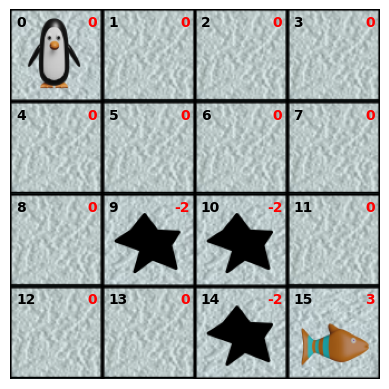

In [19]:
# We're going to work on the problem depicted in figure 19.10a
n_rows = 4; n_cols = 4
layout = np.zeros(n_rows * n_cols)
reward_structure = np.zeros(n_rows * n_cols)
layout[9] = 1 ; reward_structure[9] = -2    # Hole
layout[10] = 1; reward_structure[10] = -2   # Hole
layout[14] = 1; reward_structure[14] = -2   # Hole
layout[15] = 2; reward_structure[15] = 3    # Fish
initial_state = 0
mdp_drawer = DrawMDP(n_rows, n_cols)
mdp_drawer.draw(layout, state = initial_state, rewards=reward_structure, draw_state_index = True)

For clarity, the black numbers are the state number and the red numbers are the reward for being in that state.  Note that the states are indexed from 0 rather than 1 as in the book to make the code neater.

Now let's define the state transition function $Pr(s_{t+1}|s_{t},a)$ in full where $a$ is the actions.  Here $a=0$ means try to go upward, $a=1$, right, $a=2$ down and $a=3$ right.  However, the ice is slippery, so we don't always go the direction we want to.

Note that as for the states, we've indexed the actions from zero (unlike in the book) so they map to the indices of arrays better

In [20]:
transition_probabilities_given_action0 = np.array(\
[[0.90, 0.05, 0.00, 0.00,  0.85, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00],
 [0.05, 0.85, 0.05, 0.00,  0.00, 0.85, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00],
 [0.00, 0.05, 0.85, 0.05,  0.00, 0.00, 0.85, 0.00,  0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.05, 0.90,  0.00, 0.00, 0.00, 0.85,  0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00],
 [0.05, 0.00, 0.00, 0.00,  0.05, 0.05, 0.00, 0.00,  0.85, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00],
 [0.00, 0.05, 0.00, 0.00,  0.05, 0.00, 0.05, 0.00,  0.00, 0.85, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.05, 0.00,  0.00, 0.05, 0.00, 0.05,  0.00, 0.00, 0.85, 0.00,  0.00, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.05,  0.00, 0.00, 0.05, 0.05,  0.00, 0.00, 0.00, 0.85,  0.00, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.00,  0.05, 0.00, 0.00, 0.00,  0.05, 0.05, 0.00, 0.00,  0.85, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.00,  0.00, 0.05, 0.00, 0.00,  0.05, 0.00, 0.05, 0.00,  0.00, 0.85, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.05, 0.00,  0.00, 0.05, 0.00, 0.05,  0.00, 0.00, 0.85, 0.00],
 [0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.05,  0.00, 0.00, 0.05, 0.05,  0.00, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00,  0.05, 0.00, 0.00, 0.00,  0.10, 0.05, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00,  0.00, 0.05, 0.00, 0.00,  0.05, 0.05, 0.05, 0.00],
 [0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.05, 0.00,  0.00, 0.05, 0.05, 0.00],
 [0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.05,  0.00, 0.00, 0.05, 0.00]])


transition_probabilities_given_action1 = np.array(\
[[0.10, 0.05, 0.00, 0.00, 0.05, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
 [0.85, 0.05, 0.05, 0.00, 0.00, 0.05, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
 [0.00, 0.85, 0.05, 0.05, 0.00, 0.00, 0.05, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.85, 0.90, 0.00, 0.00, 0.00, 0.05, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
 [0.05, 0.00, 0.00, 0.00, 0.05, 0.05, 0.00, 0.00, 0.05, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
 [0.00, 0.05, 0.00, 0.00, 0.85, 0.00, 0.05, 0.00, 0.00, 0.05, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.05, 0.00, 0.00, 0.85, 0.00, 0.05, 0.00, 0.00, 0.05, 0.00, 0.00, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.05, 0.00, 0.00, 0.85, 0.85, 0.00, 0.00, 0.00, 0.05, 0.00, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.00, 0.05, 0.00, 0.00, 0.00, 0.05, 0.05, 0.00, 0.00, 0.05, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.00, 0.00, 0.05, 0.00, 0.00, 0.85, 0.00, 0.05, 0.00, 0.00, 0.05, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.05, 0.00, 0.00, 0.85, 0.00, 0.05, 0.00, 0.00, 0.05, 0.00],
 [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.05, 0.00, 0.00, 0.85, 0.85, 0.00, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.05, 0.00, 0.00, 0.00, 0.10, 0.05, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.05, 0.00, 0.00, 0.85, 0.05, 0.05, 0.00],
 [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.05, 0.00, 0.00, 0.85, 0.05, 0.00],
 [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.05, 0.00, 0.00, 0.85, 0.00]])


transition_probabilities_given_action2 = np.array(\
[[0.10, 0.05, 0.00, 0.00, 0.05, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
 [0.05, 0.05, 0.05, 0.00, 0.00, 0.05, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
 [0.00, 0.05, 0.05, 0.05, 0.00, 0.00, 0.05, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.05, 0.10, 0.00, 0.00, 0.00, 0.05, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
 [0.85, 0.00, 0.00, 0.00, 0.05, 0.05, 0.00, 0.00, 0.05, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
 [0.00, 0.85, 0.00, 0.00, 0.05, 0.00, 0.05, 0.00, 0.00, 0.05, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.85, 0.00, 0.00, 0.05, 0.00, 0.05, 0.00, 0.00, 0.05, 0.00, 0.00, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.85, 0.00, 0.00, 0.05, 0.05, 0.00, 0.00, 0.00, 0.05, 0.00, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.00, 0.85, 0.00, 0.00, 0.00, 0.05, 0.05, 0.00, 0.00, 0.05, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.00, 0.00, 0.85, 0.00, 0.00, 0.05, 0.00, 0.05, 0.00, 0.00, 0.05, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.85, 0.00, 0.00, 0.05, 0.00, 0.05, 0.00, 0.00, 0.05, 0.00],
 [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.85, 0.00, 0.00, 0.05, 0.05, 0.00, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.85, 0.00, 0.00, 0.00, 0.90, 0.05, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.85, 0.00, 0.00, 0.05, 0.85, 0.05, 0.00],
 [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.85, 0.00, 0.00, 0.05, 0.85, 0.00],
 [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.85, 0.00, 0.00, 0.05, 0.00]])

transition_probabilities_given_action3 = np.array(\
[[0.90, 0.85, 0.00, 0.00, 0.05, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
 [0.05, 0.05, 0.85, 0.00, 0.00, 0.05, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
 [0.00, 0.05, 0.05, 0.85, 0.00, 0.00, 0.05, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.05, 0.10, 0.00, 0.00, 0.00, 0.05, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
 [0.05, 0.00, 0.00, 0.00, 0.85, 0.85, 0.00, 0.00, 0.05, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
 [0.00, 0.05, 0.00, 0.00, 0.05, 0.00, 0.85, 0.00, 0.00, 0.05, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.05, 0.00, 0.00, 0.05, 0.00, 0.85, 0.00, 0.00, 0.05, 0.00, 0.00, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.05, 0.00, 0.00, 0.05, 0.05, 0.00, 0.00, 0.00, 0.05, 0.00, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.00, 0.05, 0.00, 0.00, 0.00, 0.85, 0.85, 0.00, 0.00, 0.05, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.00, 0.00, 0.05, 0.00, 0.00, 0.05, 0.00, 0.85, 0.00, 0.00, 0.05, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.05, 0.00, 0.00, 0.05, 0.00, 0.85, 0.00, 0.00, 0.05, 0.00],
 [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.05, 0.00, 0.00, 0.05, 0.05, 0.00, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.05, 0.00, 0.00, 0.00, 0.90, 0.85, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.05, 0.00, 0.00, 0.05, 0.05, 0.85, 0.00],
 [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.05, 0.00, 0.00, 0.05, 0.05, 0.00],
 [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.05, 0.00, 0.00, 0.05, 0.00]])



# Store all of these in a three dimension array
# Pr(s_{t+1}=2|s_{t}=1, a_{t}=3] is stored at position [2,1,3]
transition_probabilities_given_action = np.concatenate((np.expand_dims(transition_probabilities_given_action0,2),
                                                        np.expand_dims(transition_probabilities_given_action1,2),
                                                        np.expand_dims(transition_probabilities_given_action2,2),
                                                        np.expand_dims(transition_probabilities_given_action3,2)),axis=2)

print('Grid Size:', len(transition_probabilities_given_action[0]))
print()
print('Transition Probabilities for when next state = 2:')
print(transition_probabilities_given_action[2])
print()
print('Transitions Probabilities for when next state = 2 and current state = 1')
print(transition_probabilities_given_action[2][1])
print()
print('Transitions Probabilities for  when next state = 2 and current state = 1 and action = 3 (Left):')
print(transition_probabilities_given_action[2][1][3])

Grid Size: 16

Transition Probabilities for when next state = 2:
[[0.   0.   0.   0.  ]
 [0.05 0.85 0.05 0.05]
 [0.85 0.05 0.05 0.05]
 [0.05 0.05 0.05 0.85]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.85 0.05 0.05 0.05]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]]

Transitions Probabilities for when next state = 2 and current state = 1
[0.05 0.85 0.05 0.05]

Transitions Probabilities for  when next state = 2 and current state = 1 and action = 3 (Left):
0.05


## Implementation Details

We provide the following methods:
- **`markov_decision_process_step`** - this function simulates $Pr(s_{t+1} | s_{t}, a_{t})$. It randomly selects an action, updates the state based on the transition probabilities associated with the chosen action, and returns the new state, the reward obtained for leaving the current state, and the chosen action. The randomness in action selection and state transitions reflects a random exploration process and the stochastic nature of the MDP, respectively.

- **`get_policy`** - this function computes a policy that acts greedily with respect to the state-action values. The policy is computed for all states and the action that maximizes the state-action value is chosen for each state. When there are multiple optimal actions, one is chosen at random.


You have to implement the following method:

- **`q_learning_step`** - this function implements a single step of the Q-learning algorithm for reinforcement learning as shown below. The update follows the Q-learning formula and is controlled by parameters such as the learning rate (alpha) and the discount factor $(\gamma)$. The function returns the updated state-action values matrix.

$Q(s, a) \leftarrow (1 - \alpha) \cdot Q(s, a) + \alpha \cdot \left(r + \gamma \cdot \max_{a'} Q(s', a')\right)$

In [21]:
def get_policy(state_action_values):
    policy = np.zeros(state_action_values.shape[1]) # One action for each state
    for state in range(state_action_values.shape[1]):
        # Break ties for maximising actions randomly
        policy[state] = np.random.choice(np.flatnonzero(state_action_values[:, state] == max(state_action_values[:, state])))
    return policy

In [22]:
def markov_decision_process_step(state, transition_probabilities_given_action, reward_structure, terminal_states, action=None):
  # Pick action
  if action is None:
    action = np.random.randint(4)
  # Update the state
  new_state = np.random.choice(a=range(transition_probabilities_given_action.shape[0]), p = transition_probabilities_given_action[:, state,action])

  # Return the reward -- here the reward is for arriving at the state
  reward = reward_structure[new_state]
  is_terminal = new_state in [terminal_states]

  return new_state, reward, action, is_terminal

In [36]:
def q_learning_step(state_action_values, reward, state, new_state, action, is_terminal, gamma, alpha = 0.1):
  # TODO -- write this function
  # Replace this line
    state_action_values_after = np.copy(state_action_values)
    
    # Current Q value for the (state, action) pair
    current_q_value = state_action_values[action, state]

    # Determine the target value
    if is_terminal:
        td_target = reward
    else:
        max_future_q_value = np.max(state_action_values[:, new_state])
        td_target = reward + gamma * max_future_q_value
    
    # Temporal Difference (TD) error
    td_error = td_target - current_q_value
    
    # Update the Q value for the current state-action pair
    state_action_values_after[action, state] = current_q_value + alpha * td_error
    
    
    
    
    return state_action_values_after

Lets run this for a single Q-learning step

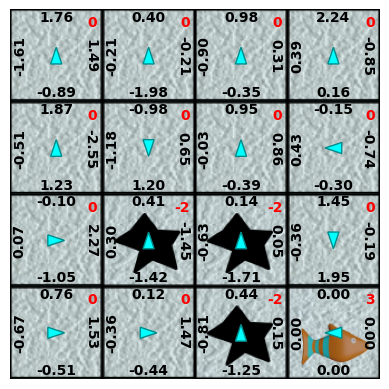

Initial state = 9
Action = 3
New state = 8
Reward = 0.0
Your value: 0.47650262412468797
True value: 0.3024718977397814


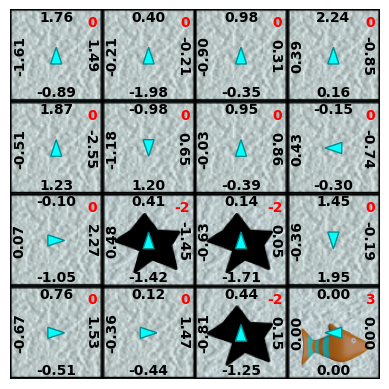

In [39]:
# Initialize the state-action values to random numbers
np.random.seed(0)
n_state = transition_probabilities_given_action.shape[0]
n_action = transition_probabilities_given_action.shape[2]
terminal_states=[15]
state_action_values = np.random.normal(size=(n_action, n_state))
# Hard code value of termination state of finding fish to 0
state_action_values[:, terminal_states] = 0
gamma = 0.9

policy = get_policy(state_action_values)
mdp_drawer = DrawMDP(n_rows, n_cols)
mdp_drawer.draw(layout, policy = policy, state_action_values = state_action_values, rewards = reward_structure)

# Now let's simulate a single Q-learning step
initial_state = 9
print("Initial state =",initial_state)
new_state, reward, action, is_terminal = markov_decision_process_step(initial_state, transition_probabilities_given_action, reward_structure, terminal_states)
print("Action =",action)
print("New state =",new_state)
print("Reward =", reward)

state_action_values_after = q_learning_step(state_action_values, reward, initial_state, new_state, action, is_terminal, gamma)
print("Your value:",state_action_values_after[action, initial_state])
print("True value: 0.3024718977397814")

policy = get_policy(state_action_values)
mdp_drawer = DrawMDP(n_rows, n_cols)
mdp_drawer.draw(layout, policy = policy, state_action_values = state_action_values_after, rewards = reward_structure)


Now let's run this for a while (20000) steps and watch the policy improve

Initial Policy:


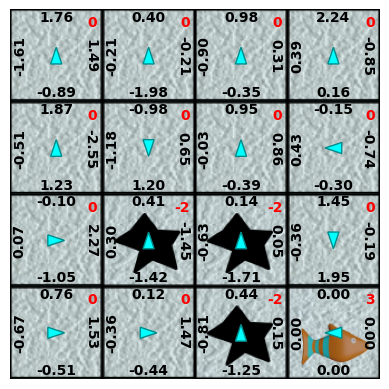

Final Optimal Policy:


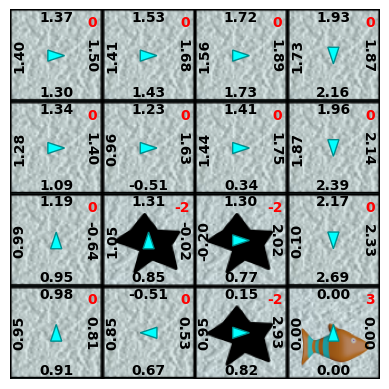

In [ ]:
# Initialize the state-action values to random numbers
np.random.seed(0)
n_state  = transition_probabilities_given_action.shape[0]
n_action = transition_probabilities_given_action.shape[2]
state_action_values = np.random.normal(size=(n_action, n_state))

# Hard code value of termination state of finding fish to 0
terminal_states = [15]
state_action_values[:, terminal_states] = 0
gamma = 0.9

# Draw the initial setup
print('Initial Policy:')
policy = get_policy(state_action_values)
mdp_drawer = DrawMDP(n_rows, n_cols)
mdp_drawer.draw(layout, policy = policy, state_action_values = state_action_values, rewards = reward_structure)

state = np.random.randint(n_state-1)

# Run for a number of iterations
for c_iter in range(20000):
  new_state, reward, action, is_terminal = markov_decision_process_step(state, transition_probabilities_given_action, reward_structure, terminal_states)
  state_action_values_after = q_learning_step(state_action_values, reward, state, new_state, action, is_terminal, gamma)

  # If in termination state, reset state randomly
  if is_terminal:
    state = np.random.randint(n_state-1)
  else:
    state = new_state

  # Update the policy
  state_action_values = deepcopy(state_action_values_after)
  policy = get_policy(state_action_values_after)

print('Final Optimal Policy:')
# Draw the final situation
mdp_drawer = DrawMDP(n_rows, n_cols)
mdp_drawer.draw(layout, policy = policy, state_action_values = state_action_values, rewards = reward_structure)

Finally, lets run this for a **single** episode and visualize the penguin's actions

In [ ]:
def get_one_episode(n_state, state_action_values, terminal_states, gamma):

    state = np.random.randint(n_state-1)

    # Create lists to store all the states seen and actions taken throughout the single episode
    all_states  = []
    all_actions = []

    # Initalize episode termination flag
    done  = False
    # Initialize counter for steps in the episode
    steps = 0

    all_states.append(state)

    while not done:
      steps += 1

      new_state, reward, action, is_terminal = markov_decision_process_step(state, transition_probabilities_given_action, reward_structure, terminal_states)
      all_states.append(new_state)
      all_actions.append(action)

      state_action_values_after = q_learning_step(state_action_values, reward, state, new_state, action, is_terminal, gamma)

      # If in termination state, reset state randomly
      if is_terminal:
        state = np.random.randint(n_state-1)
        print(f'Episode Terminated at {steps} Steps')
        # Set episode termination flag
        done = True
      else:
        state = new_state

      # Update the policy
      state_action_values = deepcopy(state_action_values_after)
      policy = get_policy(state_action_values_after)

    return all_states, all_actions, policy, state_action_values


In [ ]:
def visualize_one_episode(states, actions):
    # Define actions for visualization
    acts = ['up', 'right', 'down', 'left']

    # Iterate over the states and actions
    for i in range(len(states)):

        if i == 0:
            print('Starting State:', states[i])

        elif i == len(states)-1:
            print('Episode Done:', states[i])

        else:
            print('State', states[i-1])
            a = actions[i]
            print('Action:', acts[a])
            print('Next State:', states[i])

        # Visualize the current state using the MDP drawer
        mdp_drawer.draw(layout, state=states[i], rewards=reward_structure, draw_state_index=True)
        clear_output(True)

        # Pause for a short duration to allow observation
        sleep(1.5)


Initial Policy:


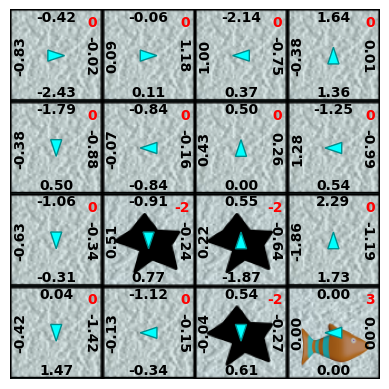

Episode Terminated at 26 Steps

Final Optimal Policy:


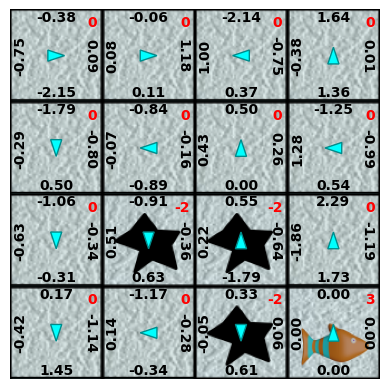

In [ ]:
# Initialize the state-action values to random numbers
np.random.seed(2)
n_state  = transition_probabilities_given_action.shape[0]
n_action = transition_probabilities_given_action.shape[2]
state_action_values = np.random.normal(size=(n_action, n_state))

# Hard code value of termination state of finding fish to 0
terminal_states = [15]
state_action_values[:, terminal_states] = 0
gamma = 0.9

# Draw the initial setup
print('Initial Policy:')
policy = get_policy(state_action_values)
mdp_drawer = DrawMDP(n_rows, n_cols)
mdp_drawer.draw(layout, policy = policy, state_action_values = state_action_values, rewards = reward_structure)

states, actions, policy, state_action_values = get_one_episode(n_state, state_action_values, terminal_states, gamma)

print()
print('Final Optimal Policy:')
mdp_drawer = DrawMDP(n_rows, n_cols)
mdp_drawer.draw(layout, policy = policy, state_action_values = state_action_values, rewards = reward_structure)


Episode Done: 15


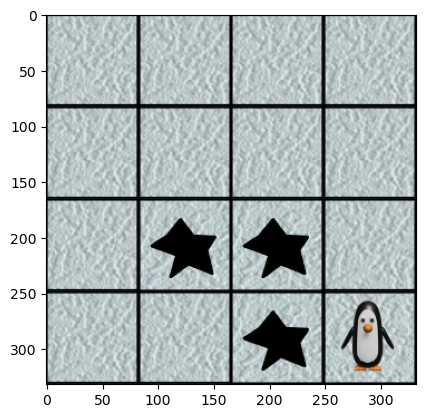

In [ ]:
visualize_one_episode(states, actions)